# The knapsack problem example

The purpose of this tutorial is to demonstrate how to formulate and solve a
simple optimization problem.

## Required packages

This tutorial requires the following packages:

In [1]:
import Pkg
using LinearAlgebra
using Random
using Plots

In [2]:
const n = 1000
const k =85
file = "dsjc1000.5.col.txt"

"dsjc1000.5.col.txt"

In [3]:
adjacence_list=Dict{Int, Vector{Int}}()
adjacence_list[1]=[2, 3, 4,5,6]
adjacence_list[2]=[1, 3, 4, 5]
adjacence_list[3]=[1, 2, 4]
adjacence_list[4]=[1, 2, 3]
adjacence_list[5]=[1, 2]
adjacence_list[6]=[1]
adjacence_list

"""
Calcul des degrés et l'ordre décroissant
"""
degree=zeros(Int, n)
for i in 1:n
    degree[i]=size(adjacence_list[i])[1]
end

indice_degree = sortperm(degree, rev=true)

KeyError: KeyError: key 7 not found

In [3]:
function define_adjacence_list(file, n)
    """
    Lecture du fichier et Création liste d'adjacence
    """
    file_read = open(file,"r");
    lines = readlines(file_read)
    adjacence_list = Dict{Int, Vector{Int}}()
    for line in lines
        st=split(line, " ")
        if st[1]=="e"
            u=parse(Int, st[2])
            v=parse(Int, st[3])
            if haskey(adjacence_list, u)
                push!(adjacence_list[u], v)
            else
                adjacence_list[u] = [v]
            end
        
            if haskey(adjacence_list, v)
                push!(adjacence_list[v], u)
            else
                adjacence_list[v] = [u]
            end
        end
    end
    return adjacence_list
end

adjacence_list=define_adjacence_list(file, n)

"""
Calcul des degrés et l'ordre décroissant
"""
degree=zeros(Int, n)
for i in 1:n
    degree[i]=size(adjacence_list[i])[1]
end

indice_degree = sortperm(degree, rev=true)

1000-element Vector{Int64}:
 916
  80
 792
 597
 428
 346
 875
 335
 833
 544
   ⋮
 566
 718
 175
 529
 606
 937
 278
 938
 551

In [4]:
function random_coloring(n, k)
    """
    Coloriage aléatoire
    """
    return rand(1:k, n)
end

random_coloring (generic function with 1 method)

In [4]:
"""
Algo glouton qui parcourt les sommets selon la degré
"""

function min_color_glouton(adjacence_list, Color, k, i)
    color_used=zeros(Int, k)
    for j in adjacence_list[i]
        if Color[j]!=0
            color_used[Color[j]]+=1
        end
    end
    for index_color in 1:k
        if color_used[index_color]==0
            return index_color
        end
    end
    return argmin(color_used)
end




function glouton(adjacence_list, indice_degree, n, k)
    Color =zeros(Int, n)
    for i in indice_degree
        Color[i]=min_color_glouton(adjacence_list, Color, k, i)
    end
    return Color
end

glouton (generic function with 1 method)

In [5]:
function count_conflict(adjacence_list, Color, n)
    """
    Compte le nombre de conflits dans une solution
    """
    Count=0
    list_conflit=[] #Liste des sommets en conflit
    bool_list_conflit=[0 for i in 1:n] # 1 si le sommet est en conflit, 0 sinon 
    for i in 1:n
        for j in adjacence_list[i]
            if Color[i]==Color[j] && j>i
                Count+=1
                if bool_list_conflit[i]==0
                    bool_list_conflit[i]=1
                    push!(list_conflit,i)
                end
                if bool_list_conflit[j]==0
                    bool_list_conflit[j]=1
                    push!(list_conflit,j)
                end
            end
        end
    end
    return Count, list_conflit
end

count_conflict (generic function with 1 method)

In [6]:
sol_glouton=glouton(adjacence_list, indice_degree, n, k)
count, list_conflit=count_conflict(adjacence_list, sol_glouton, n)

(378, Any[4, 371, 5, 790, 8, 849, 9, 775, 10, 765  …  833, 936, 844, 965, 850, 962, 854, 892, 895, 998])

In [7]:
function initialize_T_conf(adjacence_list, sol, n, k)
    T_conf=zeros(Int, n, k)
    for i in 1:n
        for j in adjacence_list[i]
            T_conf[j, sol[i]]+=1
        end
    end
    return T_conf
end

function initialize_T_conf_bis(adjacence_list, sol, degree, n, k)
    T_conf=zeros(Float64, n, k)
    for i in 1:n
        for j in adjacence_list[i]
            T_conf[j, sol[i]]+=1
        end
    end
    return T_conf
end

function best_voisinbis(adjacence_list, sol, T_conf, indice_degree, n, k)
    index=0
    c_index=0
    c_index_1=0
    max=-n
    for i in indice_degree
        for c in 1:k
            if T_conf[i, sol[i]]-T_conf[i, c]>max && c!=sol[i]
                index=i
                c_index_1=sol[i]
                c_index=c
                max = T_conf[i, sol[i]]-T_conf[i, c]
            end
        end
    end
    for j in adjacence_list[index]
        T_conf[j, c_index_1]-=1
        T_conf[j, c_index]+=1
    end
    return index, c_index, max
end


function amelioration_locale(sol, adjacence_list, indice_degree, degree, n, k)
    best_sol=deepcopy(sol)
    flag=true
    step=0
    T_conf=initialize_T_conf(adjacence_list, best_sol, n, k)
    while flag && step < 200
        index, c_index, diff = best_voisinbis(adjacence_list, best_sol, T_conf, indice_degree, n, k)
        if diff >= 1 
            best_sol[index]=c_index
        else
            flag = false
        end
        step+=1
    end
    return best_sol
end

amelioration_locale (generic function with 1 method)

In [8]:
count_conflict(adjacence_list, amelioration_locale(sol_glouton, adjacence_list, indice_degree, degree, n, k), n)

(326, Any[4, 371, 5, 790, 8, 849, 9, 775, 10, 765  …  965, 854, 892, 885, 948, 895, 929, 945, 983, 998])

In [9]:
function best_voisin_tabou(adjacence_list, sol, T_conf, tabou_matrix, indice_degree, degree, step, n, k, val_act, val_min, Frequency)
    index=0
    c_index=0
    c_index_1=0
    max=-n
    diff=-n
    for i in shuffle(indice_degree)[1:100]
        explo= -1*sqrt(log(step+1)/(Frequency[i]+1))
        for c in 1:k
            if tabou_matrix[i, c]<=step || T_conf[i, sol[i]]-T_conf[i, c]>= 0.8*(val_act-val_min)+1
                if T_conf[i, sol[i]]-T_conf[i, c]- explo>max && c!=sol[i]
                    index=i
                    c_index_1=sol[i]
                    c_index=c
                    diff = T_conf[i, sol[i]]-T_conf[i, c]
                    max = T_conf[i, sol[i]]-T_conf[i, c] - explo
                end
            end
        end
    end
    if index==0
        print(step, "ERROR")
    end
    for j in adjacence_list[index]
        T_conf[j, c_index_1]-= 1
        T_conf[j, c_index]+=1
    end
    return index, c_index, diff
end

best_voisin_tabou (generic function with 1 method)

In [14]:
function tabou(adjacence_list, indice_degree, degree, n, k, sol_init)
    sol= deepcopy(sol_init)
    best_sol=deepcopy(sol_init)
    step=0
    T_conf=initialize_T_conf_bis(adjacence_list, best_sol, degree, n, k)
    Count_init = sum([T_conf[i, sol[i]] for i in 1:n])/2
    Count=[Count_init]
    min_count=Count_init
    length_tabou=1
    tabou_matrix=zeros(Int, n,k)
    cycle=Dict{Tuple, Tuple}()
    for i in 1:n
        for c in 1:k
            cycle[i,c]=(i,c)
        end
    end
    last_change=(1,1)
    last_change_tabou=0
    Tabou_length=[1]
    Frequency = zeros(Int, n)
    time_limit = 60.0
    start_time = time()
    while time() - start_time < time_limit
        if Random.rand(1:500)==1
            tabou_matrix=zeros(Int, n,k)
            length_tabou=1
        end
        index, c_index, diff = best_voisin_tabou(adjacence_list, sol, T_conf, tabou_matrix, indice_degree, degree, step, n, k, last(Count), min_count, Frequency)
        sol[index]=c_index
        if cycle[last_change]==(index, c_index)
            if length_tabou <n*k/6 && step > last_change_tabou+length_tabou
                length_tabou+=k
                last_change_tabou=step
            end
        end
        tabou_matrix[index, c_index]=step+length_tabou
        Count_step=last(Count)-diff
        if Count_step < 0
            print("Négatif",diff)
            return sol, Count, Tabou_length
        end
        push!(Count, Count_step)
        if Count_step < min_count
            min_count=Count_step
            best_sol=deepcopy(sol)
            length_tabou=1
            tabou_matrix=zeros(Int, n,k)
            last_change_tabou=step
            print(min_count, ' ', step, '\n')
            if min_count==0
                return best_sol, Count, Tabou_length
            end
        end
        cycle[last_change]=(index, c_index)
        last_change=(index,c_index)
        step+=1
        push!(Tabou_length, length_tabou)
        Frequency[index]+=1
    end
    return best_sol, Count, Tabou_length
end

tabou (generic function with 1 method)

In [17]:
function tabou_tot(adjacence_list, indice_degree, degree, n, k)
    sol_tabou=deepcopy(sol_glouton)
    for i in 1:1
        print('\n', i, "period \n")
        sol_tabou, Count_tabou, Tabou_length=tabou(adjacence_list, indice_degree, degree, n, k, sol_tabou)
    end
    return sol_tabou
end

sol_tabou= tabou_tot(adjacence_list, indice_degree, degree, n, k)


1period 
377.0 0
376.0 1
375.0 2
374.0 3
373.0 4
371.0 5
370.0 6
369.0 7
368.0 8
367.0 9
366.0 10
365.0 11
364.0 12
363.0 13
362.0 14
361.0 15
359.0 16
357.0 17
356.0 18
355.0 19
354.0 20
353.0 21
352.0 24
351.0 25
350.0 26
349.0 27
348.0 28
347.0 29
345.0 30
344.0 31
343.0 32
342.0 33
341.0 34
340.0 36
339.0 38
338.0 39
337.0 40
336.0 41
335.0 42
333.0 43
332.0 45
331.0 46
330.0 47
329.0 49
328.0 53
327.0 54
326.0 56
325.0 57
324.0 58
323.0 62
322.0 65
321.0 72
320.0 73
319.0 74
318.0 77
317.0 78
316.0 84
315.0 91
314.0 92
313.0 96
312.0 100
311.0 106
310.0 107
309.0 112
307.0 113
306.0 118
305.0 119
304.0 120
303.0 125
302.0 128
301.0 129
300.0 133
299.0 135
298.0 137
297.0 142
296.0 143
295.0 146
294.0 148
293.0 151
292.0 153
291.0 154
289.0 156
288.0 158
287.0 159
286.0 160
285.0 161
284.0 163
283.0 168
282.0 171
281.0 172
280.0 173
279.0 174
278.0 177
277.0 180
276.0 186
275.0 188
274.0 193
273.0 194
272.0 202
271.0 203
270.0 207
269.0 236
268.0 237
267.0 240
266.0 247
265.0 251


 305
253.0 315
252.0 320
251.0 322
250.0 333
249.0 338
248.0 342
247.0 347
246.0 355
245.0 357
244.0 358
243.0 380
242.0 399
240.0 403
239.0 404
238.0 405
237.0 408
236.0 410
235.0 412
234.0 413
233.0 414
232.0 428
231.0 434
230.0 438
229.0 441
228.0 442
227.0 443
226.0 454
225.0 461
224.0 470
223.0 475
222.0 482
221.0 484
220.0 490
219.0 492
218.0 494
217.0 505
216.0 546
215.0 553
214.0 555
213.0 560
212.0 564
211.0 572
210.0 574
209.0 577
208.0 581
207.0 582
206.0 586
205.0 592
204.0 595
203.0 596
202.0 605
201.0 607
200.0 612
199.0 633
198.0 635
197.0 638
196.0 642
195.0 646
194.0 650
193.0 659
192.0 663
191.0 666
190.0 672
189.0 684
188.0 705
187.0 707


186.0 734
185.0 801
184.0 1122
183.0 1123
182.0 1426
181.0 1548
180.0 1549
179.0 1552
178.0 1556
177.0 1557
176.0 1566
175.0 1594
174.0 1596
173.0 1626
172.0 1630
171.0 1665
170.0 1666
169.0 1694
168.0 1706
167.0 1719
166.0 1740
165.0 1807
164.0 1826
163.0 1932
162.0 1951
161.0 1957
160.0 1968


159.0 2013
158.0 2054
157.0 2075
156.0 2076
155.0 2084
154.0 2085
153.0 2102
152.0 2153
151.0 2162
150.0 2167
149.0 2172
148.0 2181
146.0 2245
145.0 2251
144.0 2254
143.0 2255
142.0 2256
141.0 2337
140.0 2338
139.0 2373
138.0 2464
137.0 2479
136.0 2481
135.0 2520
134.0 2555
133.0 2692
132.0 2704
131.0 2723
130.0 2734
129.0 2766
128.0 2809
127.0 2895
126.0 2903


125.0 3828
123.0 3860
122.0 3872
121.0 4159
120.0 4171
119.0 4754
118.0 4761
117.0 4789
116.0 4818
114.0 4842
113.0 4856
112.0 4876
111.0 5033


110.0 5239
109.0 5565
108.0 5860
107.0 6011
106.0 6013
105.0 6499
104.0 6615
103.0 6647


102.0 7132
101.0 7253
100.0 7403
99.0 7541
98.0 8060


97.0 8803


96.0 11275
95.0 11937
94.0 12140


93.0 12897
92.0 12911


91.0 16811


90.0 21354
89.0 21475


88.0 22883
87.0 23105
86.0 23525
85.0 23954


84.0 24241


83.0 25687
82.0 25716
81.0 25722


80.0 37981


79.0 46550


78.0 48508


77.0 57211
76.0 57512
75.0 58041


74.0 97511
73.0 97594
72.0 98219


71.0 104810


70.0 110506


69.0 120126
68.0 120390


67.0 220040
66.0 220067
65.0 220112


64.0 228150
63.0 228344


62.0 231865
61.0 232476
60.0 232673


59.0 233910


58.0 273485


57.0 287103


56.0 380281
55.0 380576


54.0 384599


53.0 398620
52.0 400025


51.0 540966
50.0 542023
49.0 542222


48.0 552957


47.0 774398


46.0 776995


45.0 827034


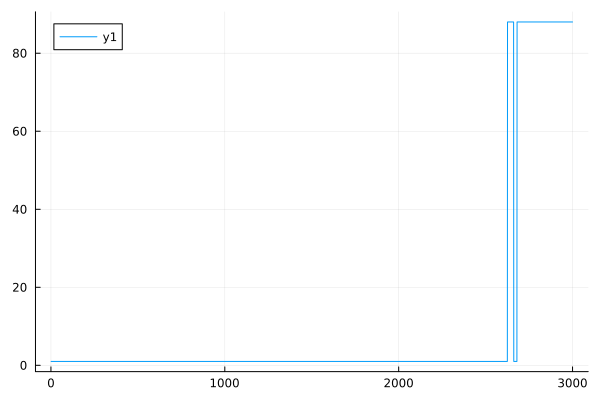

In [55]:
plot(Tabou_length[1:3000])

In [44]:
sol_tabou2, Count_tabou2, Tabou_length2=tabou(adjacence_list, indice_degree, degree, n, k, sol_glouton)
_, list_conflit_2=count_conflict(adjacence_list, sol_tabou2, n)

(2, Any[89, 111, 160, 202])

In [111]:
color_0_conflict_1=Dict{Int, Vector{Int}}()
color_0_conflict_2=Dict{Int, Vector{Int}}()
for c in 1:k
    color_0_conflict_1[c]=[]
    color_0_conflict_2[c]=[]
end
for i in 1:n
    if !(i in list_conflit_1)
        push!(color_0_conflict_1[sol_tabou[i]], i)
    end
    if !(i in list_conflit_2)
        push!(color_0_conflict_2[sol_tabou2[i]], i)
    end
end
color_0_conflict_1

Dict{Int64, Vector{Int64}} with 28 entries:
  5  => [24, 66, 73, 114, 159, 190, 205, 213]
  16 => [13, 16, 35, 75, 89, 126, 151, 185, 224]
  20 => [53, 80, 97, 100, 105, 113, 128, 142, 166, 210, 233, 246]
  12 => [28, 50, 59, 67, 98, 136, 165]
  24 => [17, 37, 39, 96, 101, 116, 149, 189, 211, 232, 234]
  28 => [30, 33, 71, 76, 83, 95, 140, 154, 195, 199]
  8  => [11, 14, 72, 117, 145, 146, 175, 200, 226]
  17 => [46, 69, 87, 93, 167, 174, 183, 206]
  1  => [23, 38, 40, 57, 65, 107, 130, 138, 238]
  19 => [5, 6, 45, 49, 118, 121, 141, 148, 162]
  22 => [127, 172, 186, 204, 208, 218, 223, 245, 247, 250]
  23 => [54, 81, 104, 109, 158, 187, 197, 203, 214, 219]
  6  => [18, 26, 135, 143, 147, 157, 170, 179, 222]
  11 => [34, 52, 68, 78, 137, 139, 144, 169, 177]
  9  => [60, 79, 82, 198, 209, 216, 229, 240]
  14 => [20, 29, 41, 70, 86, 92, 193, 231]
  3  => [10, 31, 44, 55, 125, 168, 191, 196]
  7  => [7, 64, 77, 90, 94, 134, 160, 176, 201, 242]
  25 => [12, 63, 129, 194, 221, 227, 230, 248

In [112]:
sol_fusion=zeros(Int, n)
c=0
for i in list_conflit_1
    c+=1
    for j in color_0_conflict_2[sol_tabou2[i]]
        sol_fusion[j]=c
        deleteat!(color_0_conflict_1[sol_tabou[j]], findall(x->x==j, color_0_conflict_1[sol_tabou[j]]))
    color_0_conflict_2[sol_tabou2[i]]=[]
    end
end
for i in list_conflit_2
    c+=1
    for j in color_0_conflict_1[sol_tabou[i]]
        sol_fusion[j]=c
        deleteat!(color_0_conflict_2[sol_tabou2[j]], findall(x->x==j, color_0_conflict_2[sol_tabou2[j]]))
    color_0_conflict_1[sol_tabou[i]]=[]
    end
end
c+=1
while c<=k
    first_c_1 = sort(collect(keys(color_0_conflict_1)), by=x->length(color_0_conflict_1[x]), rev=true)[1]
    first_c_2 = sort(collect(keys(color_0_conflict_1)), by=x->length(color_0_conflict_2[x]), rev=true)[1]
    if size(color_0_conflict_1[first_c_1]) >= size(color_0_conflict_2[first_c_2])
        for j in color_0_conflict_1[first_c_1]
            sol_fusion[j]=c
            deleteat!(color_0_conflict_2[sol_tabou2[j]], findall(x->x==j, color_0_conflict_2[sol_tabou2[j]]))
        color_0_conflict_1[first_c_1]=[]
        end
    else
        for j in color_0_conflict_2[first_c_2]
            sol_fusion[j]=c
            deleteat!(color_0_conflict_1[sol_tabou[j]], findall(x->x==j, color_0_conflict_1[sol_tabou[j]]))
        color_0_conflict_2[first_c_2]=[]
        end
    end
    c+=1
end

for j in 1:n
    if sol_fusion[j]==0
        sol_fusion[j]=j%k+1
    end
end

count_conflict(adjacence_list, sol_fusion, n)

(119, Any[2, 196, 3, 102, 4, 5, 48, 188, 6, 7  …  172, 186, 204, 218, 247, 250, 190, 240, 205, 234])

In [113]:
sol_fusion[89]
for j in 1:n
    if sol_fusion[j]==0
        print(j, ' ')
    end
end

In [114]:
sol_tabou3, Count_tabou3, Tabou_length3=tabou(adjacence_list, indice_degree, degree, n, k, sol_fusion)
count_conflict(adjacence_list, sol_tabou3, n)

(3, Any[148, 159, 150, 180, 225, 250])

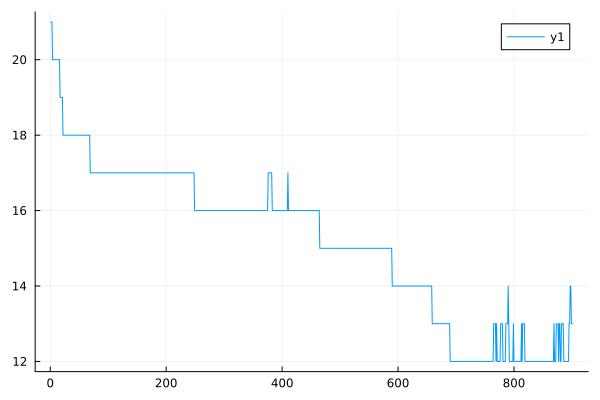

In [120]:
plot(Count_tabou3[100:1000])
# Count_tabou[4000000:5000000]
# sum(Count_tabou[400000:500000])/100000

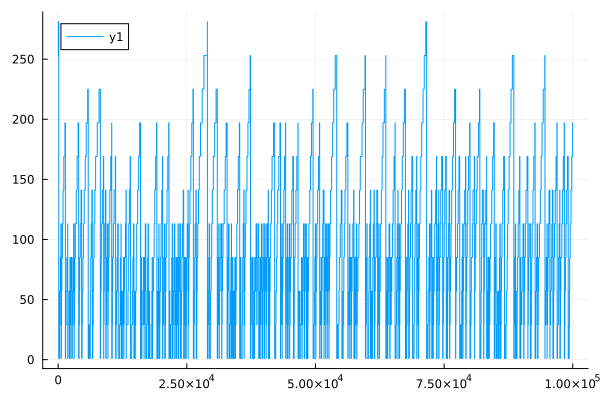

In [24]:
plot(Tabou_length[500000:600000])

In [114]:
function genetic(adjacence_list, indice_degree, degree, n, k)
    Parents= [random_coloring(n, k) for i in 1:4]
    step=0
    while step <=2
        for i in 1:4
            Parents[i]=tabou(adjacence_list, indice_degree, degree, n, k, Parents[i])[1]
        end
    step+=1
    end
end

genetic (generic function with 1 method)

In [115]:
sol_genetic= genetic(adjacence_list, indice_degree, degree, n, k)
count_conflict(adjacence_list, sol_genetic, n)

MethodError: MethodError: no method matching getindex(::Nothing, ::Int64)

In [21]:
distance_matrix=zeros(Int, n,n)
for i in 1:n
    for j in 1:n
        distance_matrix[i,j]=100000
    end
end

for i in 1:n
    for j in adjacence_list[i]
        distance_matrix[i,j]=1
    end
end
for i in 1:n
    for k in 1:n
        for j in 1:n
            if distance_matrix[i,j]+distance_matrix[j,k]<distance_matrix[i,k]
                distance_matrix[i,k]=distance_matrix[i,j]+distance_matrix[j,k]
            end
        end
    end
end

distance_matrix

1000×1000 Matrix{Int64}:
 2  2  1  2  2  2  1  1  2  1  1  1  1  …  2  2  1  1  1  1  1  2  1  2  2  2
 2  2  2  1  2  2  1  2  2  2  1  2  1     1  2  1  1  2  1  2  2  2  2  1  1
 1  2  2  1  2  1  1  1  1  1  1  2  1     1  1  1  1  2  1  1  1  2  1  1  2
 2  1  1  2  1  1  1  1  1  2  2  1  2     1  2  1  1  1  2  2  1  2  2  2  1
 2  2  2  1  2  1  1  2  1  2  1  2  1     1  2  2  2  2  2  2  1  1  2  1  2
 2  2  1  1  1  2  2  2  1  2  2  1  2  …  2  1  2  1  1  1  2  2  1  2  1  2
 1  1  1  1  1  2  2  2  2  1  2  2  2     2  2  2  2  1  1  2  1  1  1  1  1
 1  2  1  1  2  2  2  2  1  1  1  1  1     1  1  1  2  2  2  2  1  2  1  2  1
 2  2  1  1  1  1  2  1  2  1  1  1  1     2  1  1  1  1  2  1  1  2  2  1  1
 1  2  1  2  2  2  1  1  1  2  1  1  2     2  1  2  1  1  2  2  1  1  2  1  1
 ⋮              ⋮              ⋮        ⋱        ⋮              ⋮           
 1  1  1  1  2  1  2  2  1  1  1  2  1     2  1  2  2  2  1  1  2  1  1  2  1
 1  2  2  1  2  1  1  2  1  1  2  2  1  

In [43]:
# a=Random.rand(1:n)
# print(a, ' ', a+Int(n/2))
shuffle(indice_degree)[1:500]

500-element Vector{Int64}:
 578
 940
 819
 446
 220
 424
 503
 330
 450
 366
   ⋮
 368
  86
 670
 388
  99
  10
 480
 397
 101